In [ ]:
!pip install catboost

**Disclaimer** - работало на машине с 72 ядрами CPU и 60 Gb RAM

Запускать весь код на личной машине может быть очень опрометчиво. В первую очередь это относится ко всему, что касается пердобработки данных

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import t

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, average_precision_score

from catboost import CatBoostClassifier

import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

---

# 1 - Загрузка данных

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "mgcpr1337"
os.environ['KAGGLE_KEY']      = "___"
!kaggle datasets download -d wordsforthewise/lending-club

In [ ]:
!unzip lending-club.zip

In [2]:
%%time
df_acc = pd.read_csv(
    'accepted_2007_to_2018Q4.csv.gz',
    compression = 'gzip'
)

CPU times: user 29.4 s, sys: 10.3 s, total: 39.7 s
Wall time: 45.7 s


В работе будем использовать `df_acc`, так как он содержит больше полезной информации

---

# 2 - Очистка данных и работа с фичами

1) Уберем строки без данных

In [3]:
%%time

df_acc['calc_nulls'] = df_acc.isnull().sum(axis=1)
df_acc = df_acc[df_acc.calc_nulls < 150]
df_acc.drop(columns=['calc_nulls'], inplace=True)

df_acc

CPU times: user 10.8 s, sys: 5.56 s, total: 16.3 s
Wall time: 19.2 s


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN

2) Добавим в данные таргет

In [4]:
%%time

df_acc['target'] = df_acc.loan_status.apply(
    lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default'] else 0
)
df_acc.drop(columns=['loan_status'], inplace=True)

df_acc

CPU times: user 1.66 s, sys: 1.97 s, total: 3.62 s
Wall time: 4.51 s


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

3) Объединим 2 сценария работы (`Joint App` и `Individual`) в один столбец

In [5]:
%%time

df_acc['modified_annual_inc'] = df_acc.apply(lambda x: x.annual_inc_joint if x.application_type == 'Joint App' else x.annual_inc, axis=1)
df_acc['modified_dti'] = df_acc.apply(lambda x: x.dti_joint if x.application_type == 'Joint App' else x.dti, axis=1)
df_acc['modified_verification_status'] = df_acc.apply(lambda x: x.verification_status_joint if x.application_type == 'Joint App' else x.verification_status, axis=1)
df_acc['modified_revol_bal'] = df_acc.apply(lambda x: x.revol_bal_joint if x.application_type == 'Joint App' else x.revol_bal, axis=1)
df_acc['modified_dti_ratio'] = df_acc['modified_dti'] / df_acc['dti']

df_acc.drop(
    columns=[
        'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint',
        'annual_inc', 'dti', 'verification_status', 'revol_bal',
    ],
    inplace=True
)

df_acc

CPU times: user 2min 40s, sys: 1min 31s, total: 4min 11s
Wall time: 5min


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0,55000.0,5.91,Not Verified,2765.0,1.000000
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N

4) Посмотрим на долю NULL в данных

In [6]:
tmp = df_acc.isnull().mean().sort_values().to_frame().reset_index()
tmp.columns = ['column', 'null_share']
tmp.null_share = tmp.null_share.round(2)

tmp

,column,null_share
0,id,0.00
1,fico_range_high,0.00
2,initial_list_status,0.00
3,out_prncp,0.00
4,out_prncp_inv,0.00
5,total_pymnt,0.00
6,total_pymnt_inv,0.00
7,total_rec_prncp,0.00
8,fico_range_low,0.00
9,total_rec_int,0.00


5) Удалим столбцы, которые состоят из NULL'ов

In [7]:
%%time

df_acc.drop(columns=tmp[tmp.null_share == 1].column.tolist(), inplace=True)

df_acc

CPU times: user 879 ms, sys: 1.62 s, total: 2.5 s
Wall time: 3.26 s


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0,55000.0,5.91,Not Verified,2765.0,1.000000
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0,65000.0,16.06,Not Verified,21470.0,1.000000
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,Jun-2017,15813.30,NaN,Mar-2019,704.0,700.

6) Посмотрим на те столбцы, которые на 90+% состоят из NULL

In [8]:
df_desc = pd.read_csv('Lending Club Data Dictionary Approved.csv', encoding='latin-1')
df_desc = df_desc[['LoanStatNew', 'Description']]
df_desc

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
5,annual_inc_joint,The combined self-reported annual income provi...
6,application_type,Indicates whether the loan is an individual ap...
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/...


In [9]:
tmp = df_acc.isnull().mean().sort_values().to_frame().reset_index()
tmp.columns = ['column', 'null_share']
tmp.null_share = tmp.null_share.round(2)

tmp = pd.merge(
    left=tmp,
    right=df_desc,
    left_on='column',
    right_on='LoanStatNew',
    how='left'
)
tmp.drop(columns=['LoanStatNew'], inplace=True)

tmp[tmp.null_share >= 0.9]

,column,null_share,Description
114,desc,0.94,Loan description provided by the borrower
115,sec_app_open_acc,0.95,NaN
116,sec_app_fico_range_low,0.95,NaN
117,sec_app_mort_acc,0.95,NaN
118,sec_app_fico_range_high,0.95,NaN
119,sec_app_open_act_il,0.95,Number of currently active installment trades...
120,sec_app_collections_12_mths_ex_med,0.95,NaN
121,sec_app_chargeoff_within_12_mths,0.95,NaN
122,sec_app_num_rev_accts,0.95,NaN
123,sec_app_inq_last_6mths,0.95,NaN


7) Спокойно можем их удалять

In [10]:
%%time

df_acc.drop(columns=tmp[tmp.null_share >= 0.9].column.tolist(), inplace=True)

df_acc

CPU times: user 644 ms, sys: 907 ms, total: 1.55 s
Wall time: 1.96 s


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,0,55000.0,5.91,Not Verified,2765.0,1.000000
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,0,65000.0,16.06,Not Verified,21470.0,1.000000
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,Jun-2017,15813.30,NaN,Mar-2019,704.0,700.0,0.0,NaN,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,0,71000.0,13.85,Not Verified,NaN,1.284787
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,0.0

8) Удалим столбцы, которых не могло быть на момент создания анкеты. Это - потенциальные утечки таргета

In [11]:
leaks = [
    'acc_now_delinq',
    'acc_open_past_24mths',
    'addr_state',
    'bc_open_to_buy',
    'bc_util',
    'chargeoff_within_12_mths',
    'collection_recovery_fee',
    'collections_12_mths_ex_med',
    'debt_settlement_flag',
    'delinq_2yrs',
    'delinq_amnt',
    'disbursement_method',
    'funded_amnt_inv',
    'hardship_flag',
    'initial_list_status',
    'inq_last_6mths',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl',
    'mths_since_recent_bc',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats',
    'num_tl_120dpd_2m',
    'num_tl_30dpd',
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'out_prncp',
    'out_prncp_inv',
    'pct_tl_nvr_dlq',
    'percent_bc_gt_75',
    'pymnt_plan',
    'recoveries',
    'tax_liens',
    'tot_coll_amt',
    'tot_cur_bal',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    'total_rev_hi_lim',
    'url'
]

df_acc.drop(columns=leaks, inplace=True)
df_acc

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,purpose,title,zip_code,earliest_cr_line,fico_range_low,fico_range_high,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,next_pymnt_d,mths_since_last_major_derog,policy_code,application_type,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,Dec-2015,debt_consolidation,Debt consolidation,190xx,Aug-2003,675.0,679.0,30.0,NaN,7.0,0.0,29.7,13.0,NaN,30.0,1.0,Individual,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,20701.0,1.0,69.0,69.0,0.0,0,55000.0,5.91,Not Verified,2765.0,1.000000
1,68355089,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,Dec-2015,small_business,Business,577xx,Dec-1999,715.0,719.0,6.0,NaN,22.0,0.0,19.2,38.0,NaN,NaN,1.0,Individual,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,9733.0,4.0,NaN,6.0,0.0,0,65000.0,16.06,Not Verified,21470.0,1.000000
2,68341763,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,Dec-2015,home_improvement,NaN,605xx,Aug-2000,695.0,699.0,NaN,NaN,6.0,0.0,56.2,18.0,NaN,NaN,1.0,Joint App,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,2.0,5.0,1.0,31617.0,5.0,NaN,NaN,0.0,0,71000.0,13.85,Not Verified,NaN,1.284787
3,66310712,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,Dec-2015,debt_consolidation,Debt consolidation,076xx,Sep-2008,785.0,789.0,NaN,NaN,13.0,0.0,11.6,17.0,Apr-2019,NaN,1.0,Individual,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,0.0,1.0,0.0,23192.0,1.0,NaN,NaN,0.0,0,110000.0,17.06,Source Verified,7802.0,1.000000
4,68476807,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,Dec-2015,major_purchase,Major purchase,174xx,Jun-1998,695.0,699.0,12.0,NaN,12.0,0.0,64.5,35.0,NaN,NaN,1.0,Individual,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,27644.0,6.0,12.0,12.0,0.0,0,104433.0,25.37,Source Verified,21929.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,60 months,12.79,543.50,C,C1,Unit Operator,7 years,MORTGAGE,Oct-2016,home_improvement,Home improvement,356xx,Dec-1999,665.0,669.0,NaN,NaN,5.0,0.0,84.4,54.0,Apr-2019,NaN,1.0,Individual,2.0,2.0,1.0,3.0,3.0,54991.0,106.0,2.0,2.0,0.0,103.0,1.0,19.0,1.0,26106.0,0.0,NaN,NaN,0.0,0,95000.0,19.61,Source Verified,49431.0,1.000000
2260695,88977788,24000.0,24000.0,60 months,10.49,515.74,B,B3,Database Administrator,10+ years,MORTGAGE,Oct-2016,debt_consolidation,Debt consolidation,840xx,Feb-1991,695.0,699.0,60.0,69.0,24.0,1.0,39.0,58.0,Apr-2019,60.0,1.0,Individual,0.0,4.0,0.0,5.0,16.0,118453.0,77.0,0.0,2.0,4090.0,59.0,1.0,12.0,4.0,6369.0,4.0,60.0,60.0,0.0,0,108000.0,34.94,Not Verified,21665.0,1.000000
2260696,88985880,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,9 years,MORTGAGE,Oct-2016,debt_consolidation,NaN,907xx,Feb-1995,705.0,709.0,9.0,NaN,5.0,0.0,64.9,37.0,Apr-2019,10.0,1.0,Individual,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,3.0,0.0,2.0,5680.0,3.0,9.0,9.0,0.0,0,227000.0,12.75,Verified,8633.0,1.000000
2260697,88224441,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,6 years,RENT,Oct-2016,debt_consolidation,Debt consolidation,334xx,Jul-1999,660.0,664.0,67.0,72.0,10.0,1.0,68.1,31.0,NaN,67.0,1.0,Individual,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,0.0,0.0,1.0,6243.0,2.0,NaN,N

9) Дропнем еще бесполезных фичей

In [12]:
useless = [
    'fico_range_high',
    'next_pymnt_d'
]

df_acc.drop(columns=useless, inplace=True)
df_acc

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,purpose,title,zip_code,earliest_cr_line,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,mths_since_last_major_derog,policy_code,application_type,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,Dec-2015,debt_consolidation,Debt consolidation,190xx,Aug-2003,675.0,30.0,NaN,7.0,0.0,29.7,13.0,30.0,1.0,Individual,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,20701.0,1.0,69.0,69.0,0.0,0,55000.0,5.91,Not Verified,2765.0,1.000000
1,68355089,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,Dec-2015,small_business,Business,577xx,Dec-1999,715.0,6.0,NaN,22.0,0.0,19.2,38.0,NaN,1.0,Individual,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,9733.0,4.0,NaN,6.0,0.0,0,65000.0,16.06,Not Verified,21470.0,1.000000
2,68341763,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,Dec-2015,home_improvement,NaN,605xx,Aug-2000,695.0,NaN,NaN,6.0,0.0,56.2,18.0,NaN,1.0,Joint App,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,2.0,5.0,1.0,31617.0,5.0,NaN,NaN,0.0,0,71000.0,13.85,Not Verified,NaN,1.284787
3,66310712,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,Dec-2015,debt_consolidation,Debt consolidation,076xx,Sep-2008,785.0,NaN,NaN,13.0,0.0,11.6,17.0,NaN,1.0,Individual,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,0.0,1.0,0.0,23192.0,1.0,NaN,NaN,0.0,0,110000.0,17.06,Source Verified,7802.0,1.000000
4,68476807,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,Dec-2015,major_purchase,Major purchase,174xx,Jun-1998,695.0,12.0,NaN,12.0,0.0,64.5,35.0,NaN,1.0,Individual,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,27644.0,6.0,12.0,12.0,0.0,0,104433.0,25.37,Source Verified,21929.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,60 months,12.79,543.50,C,C1,Unit Operator,7 years,MORTGAGE,Oct-2016,home_improvement,Home improvement,356xx,Dec-1999,665.0,NaN,NaN,5.0,0.0,84.4,54.0,NaN,1.0,Individual,2.0,2.0,1.0,3.0,3.0,54991.0,106.0,2.0,2.0,0.0,103.0,1.0,19.0,1.0,26106.0,0.0,NaN,NaN,0.0,0,95000.0,19.61,Source Verified,49431.0,1.000000
2260695,88977788,24000.0,24000.0,60 months,10.49,515.74,B,B3,Database Administrator,10+ years,MORTGAGE,Oct-2016,debt_consolidation,Debt consolidation,840xx,Feb-1991,695.0,60.0,69.0,24.0,1.0,39.0,58.0,60.0,1.0,Individual,0.0,4.0,0.0,5.0,16.0,118453.0,77.0,0.0,2.0,4090.0,59.0,1.0,12.0,4.0,6369.0,4.0,60.0,60.0,0.0,0,108000.0,34.94,Not Verified,21665.0,1.000000
2260696,88985880,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,9 years,MORTGAGE,Oct-2016,debt_consolidation,NaN,907xx,Feb-1995,705.0,9.0,NaN,5.0,0.0,64.9,37.0,10.0,1.0,Individual,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,3.0,0.0,2.0,5680.0,3.0,9.0,9.0,0.0,0,227000.0,12.75,Verified,8633.0,1.000000
2260697,88224441,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,6 years,RENT,Oct-2016,debt_consolidation,Debt consolidation,334xx,Jul-1999,660.0,67.0,72.0,10.0,1.0,68.1,31.0,67.0,1.0,Individual,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,0.0,0.0,1.0,6243.0,2.0,NaN,NaN,1.0,1,110000.0,18.30,Not Verified,17641.0,1.000000


10) Смотрим на фичи, которые пережили предыдущие итерации

In [13]:
tmp[tmp.column.isin(df_acc.columns)]

,column,null_share,Description
0,id,0.00,A unique LC assigned ID for the loan listing.
15,policy_code,0.00,publicly available policy_code=1\nnew products...
16,application_type,0.00,Indicates whether the loan is an individual ap...
18,fico_range_low,0.00,The lower boundary range the borrowers FICO a...
20,int_rate,0.00,Interest Rate on the loan
22,home_ownership,0.00,The home ownership status provided by the borr...
23,issue_d,0.00,The month which the loan was funded
26,target,0.00,NaN
27,installment,0.00,The monthly payment owed by the borrower if th...
28,sub_grade,0.00,LC assigned loan subgrade


11) Кодируем категориальные признаки, для которых важно отношение порядка

In [14]:
term_to_int = {
    ' 36 months': 1,
    ' 60 months': 2
}
grade_to_int = dict(
    zip(
        ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
        np.arange(7, 0, -1)
    )
)
sub_grade_sorted = dict(
    zip(
        [
            'G5', 'G4', 'G3', 'G2', 'G1',
            'F5', 'F4', 'F3', 'F2', 'F1',
            'E5', 'E4', 'E3', 'E2', 'E1',
            'D5', 'D4', 'D3', 'D2', 'D1',
            'C5', 'C4', 'C3', 'C2', 'C1',
            'B5', 'B4', 'B3', 'B2', 'B1',
            'A5', 'A4', 'A3', 'A2', 'A1',
        ],
        np.arange(0, 35, 1)
    )
)
home_to_int = {
    'OWN': 5,
    'MORTGAGE': 4,
    'RENT': 3,
    'ANY': 2,
    'OTHER': 1,
    'NONE':0
}
ver_stat_to_int = {
    'Source Verified': 2,
    'Verified': 1,
    'Not Verified': 0
}
dict_emp_length = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years':10
}
df_acc.emp_length.fillna("< 1 year", inplace= True)

df_acc.replace(
    {
        'term': term_to_int,
        'grade':grade_to_int,
        'sub_grade': sub_grade_sorted,
        'home_ownership':home_to_int,
        'modified_verification_status':ver_stat_to_int,
        'emp_length': dict_emp_length
    },
    inplace=True
)

df_acc

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,purpose,title,zip_code,earliest_cr_line,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,mths_since_last_major_derog,policy_code,application_type,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,3600.0,3600.0,1,13.99,123.03,5,21,leadman,10.0,4,Dec-2015,debt_consolidation,Debt consolidation,190xx,Aug-2003,675.0,30.0,NaN,7.0,0.0,29.7,13.0,30.0,1.0,Individual,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,20701.0,1.0,69.0,69.0,0.0,0,55000.0,5.91,0.0,2765.0,1.000000
1,68355089,24700.0,24700.0,1,11.99,820.28,5,24,Engineer,10.0,4,Dec-2015,small_business,Business,577xx,Dec-1999,715.0,6.0,NaN,22.0,0.0,19.2,38.0,NaN,1.0,Individual,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,9733.0,4.0,NaN,6.0,0.0,0,65000.0,16.06,0.0,21470.0,1.000000
2,68341763,20000.0,20000.0,2,10.78,432.66,6,26,truck driver,10.0,4,Dec-2015,home_improvement,NaN,605xx,Aug-2000,695.0,NaN,NaN,6.0,0.0,56.2,18.0,NaN,1.0,Joint App,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,2.0,5.0,1.0,31617.0,5.0,NaN,NaN,0.0,0,71000.0,13.85,0.0,NaN,1.284787
3,66310712,35000.0,35000.0,2,14.85,829.90,5,20,Information Systems Officer,10.0,4,Dec-2015,debt_consolidation,Debt consolidation,076xx,Sep-2008,785.0,NaN,NaN,13.0,0.0,11.6,17.0,NaN,1.0,Individual,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,0.0,1.0,0.0,23192.0,1.0,NaN,NaN,0.0,0,110000.0,17.06,2.0,7802.0,1.000000
4,68476807,10400.0,10400.0,2,22.45,289.91,2,9,Contract Specialist,3.0,4,Dec-2015,major_purchase,Major purchase,174xx,Jun-1998,695.0,12.0,NaN,12.0,0.0,64.5,35.0,NaN,1.0,Individual,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,27644.0,6.0,12.0,12.0,0.0,0,104433.0,25.37,2.0,21929.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,2,12.79,543.50,5,24,Unit Operator,7.0,4,Oct-2016,home_improvement,Home improvement,356xx,Dec-1999,665.0,NaN,NaN,5.0,0.0,84.4,54.0,NaN,1.0,Individual,2.0,2.0,1.0,3.0,3.0,54991.0,106.0,2.0,2.0,0.0,103.0,1.0,19.0,1.0,26106.0,0.0,NaN,NaN,0.0,0,95000.0,19.61,2.0,49431.0,1.000000
2260695,88977788,24000.0,24000.0,2,10.49,515.74,6,27,Database Administrator,10.0,4,Oct-2016,debt_consolidation,Debt consolidation,840xx,Feb-1991,695.0,60.0,69.0,24.0,1.0,39.0,58.0,60.0,1.0,Individual,0.0,4.0,0.0,5.0,16.0,118453.0,77.0,0.0,2.0,4090.0,59.0,1.0,12.0,4.0,6369.0,4.0,60.0,60.0,0.0,0,108000.0,34.94,0.0,21665.0,1.000000
2260696,88985880,40000.0,40000.0,2,10.49,859.56,6,27,Vice President,9.0,4,Oct-2016,debt_consolidation,NaN,907xx,Feb-1995,705.0,9.0,NaN,5.0,0.0,64.9,37.0,10.0,1.0,Individual,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,3.0,0.0,2.0,5680.0,3.0,9.0,9.0,0.0,0,227000.0,12.75,1.0,8633.0,1.000000
2260697,88224441,24000.0,24000.0,2,14.49,564.56,5,21,Program Manager,6.0,3,Oct-2016,debt_consolidation,Debt consolidation,334xx,Jul-1999,660.0,67.0,72.0,10.0,1.0,68.1,31.0,67.0,1.0,Individual,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,0.0,0.0,1.0,6243.0,2.0,NaN,NaN,1.0,1,110000.0,18.30,0.0,17641.0,1.000000


12) Кодируем все, что осталось

In [15]:
col = ['purpose', 'application_type']
enc = LabelEncoder()
df_acc.loc[:, col] = df_acc.loc[:, col].apply(enc.fit_transform)

df_acc

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,issue_d,purpose,title,zip_code,earliest_cr_line,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,mths_since_last_major_derog,policy_code,application_type,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio
0,68407277,3600.0,3600.0,1,13.99,123.03,5,21,leadman,10.0,4,Dec-2015,2,Debt consolidation,190xx,Aug-2003,675.0,30.0,NaN,7.0,0.0,29.7,13.0,30.0,1.0,0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,20701.0,1.0,69.0,69.0,0.0,0,55000.0,5.91,0.0,2765.0,1.000000
1,68355089,24700.0,24700.0,1,11.99,820.28,5,24,Engineer,10.0,4,Dec-2015,11,Business,577xx,Dec-1999,715.0,6.0,NaN,22.0,0.0,19.2,38.0,NaN,1.0,0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,9733.0,4.0,NaN,6.0,0.0,0,65000.0,16.06,0.0,21470.0,1.000000
2,68341763,20000.0,20000.0,2,10.78,432.66,6,26,truck driver,10.0,4,Dec-2015,4,NaN,605xx,Aug-2000,695.0,NaN,NaN,6.0,0.0,56.2,18.0,NaN,1.0,1,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,2.0,5.0,1.0,31617.0,5.0,NaN,NaN,0.0,0,71000.0,13.85,0.0,NaN,1.284787
3,66310712,35000.0,35000.0,2,14.85,829.90,5,20,Information Systems Officer,10.0,4,Dec-2015,2,Debt consolidation,076xx,Sep-2008,785.0,NaN,NaN,13.0,0.0,11.6,17.0,NaN,1.0,0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,0.0,1.0,0.0,23192.0,1.0,NaN,NaN,0.0,0,110000.0,17.06,2.0,7802.0,1.000000
4,68476807,10400.0,10400.0,2,22.45,289.91,2,9,Contract Specialist,3.0,4,Dec-2015,6,Major purchase,174xx,Jun-1998,695.0,12.0,NaN,12.0,0.0,64.5,35.0,NaN,1.0,0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,27644.0,6.0,12.0,12.0,0.0,0,104433.0,25.37,2.0,21929.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,2,12.79,543.50,5,24,Unit Operator,7.0,4,Oct-2016,4,Home improvement,356xx,Dec-1999,665.0,NaN,NaN,5.0,0.0,84.4,54.0,NaN,1.0,0,2.0,2.0,1.0,3.0,3.0,54991.0,106.0,2.0,2.0,0.0,103.0,1.0,19.0,1.0,26106.0,0.0,NaN,NaN,0.0,0,95000.0,19.61,2.0,49431.0,1.000000
2260695,88977788,24000.0,24000.0,2,10.49,515.74,6,27,Database Administrator,10.0,4,Oct-2016,2,Debt consolidation,840xx,Feb-1991,695.0,60.0,69.0,24.0,1.0,39.0,58.0,60.0,1.0,0,0.0,4.0,0.0,5.0,16.0,118453.0,77.0,0.0,2.0,4090.0,59.0,1.0,12.0,4.0,6369.0,4.0,60.0,60.0,0.0,0,108000.0,34.94,0.0,21665.0,1.000000
2260696,88985880,40000.0,40000.0,2,10.49,859.56,6,27,Vice President,9.0,4,Oct-2016,2,NaN,907xx,Feb-1995,705.0,9.0,NaN,5.0,0.0,64.9,37.0,10.0,1.0,0,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,3.0,0.0,2.0,5680.0,3.0,9.0,9.0,0.0,0,227000.0,12.75,1.0,8633.0,1.000000
2260697,88224441,24000.0,24000.0,2,14.49,564.56,5,21,Program Manager,6.0,3,Oct-2016,2,Debt consolidation,334xx,Jul-1999,660.0,67.0,72.0,10.0,1.0,68.1,31.0,67.0,1.0,0,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,0.0,0.0,1.0,6243.0,2.0,NaN,NaN,1.0,1,110000.0,18.30,0.0,17641.0,1.000000


13) Заполняем NULL средними значениями

In [16]:
for i in df_acc.columns[df_acc.isnull().any(axis=0)]:
    if df_acc[i].dtype != 'object':
        df_acc[i].fillna(df_acc[i].mean(), inplace=True)

14) Последние штрихи - выводим еще дополнительные фичи

In [17]:
%%time

df_acc['modified_obligations'] = df_acc['modified_dti'] * df_acc['modified_annual_inc'] / 12
df_acc['modified_obligations2bal'] = df_acc['modified_obligations'] / df_acc['avg_cur_bal']

df_acc['modified_zip_code_1sign'] = df_acc['zip_code'].str[0:1]
df_acc['modified_zip_code_2sign'] = df_acc['zip_code'].str[0:2]
df_acc['modified_pub_rec_total'] = df_acc['pub_rec_bankruptcies'] + df_acc['pub_rec']

df_acc['modified_emp_title_f'] = np.where(df_acc['emp_title'].notnull(),1,0)
df_acc['modified_title_f'] = np.where(df_acc['title'].notnull(),1,0)

df_acc.drop(columns=['emp_title', 'title', 'zip_code'], inplace=True)
df_acc

CPU times: user 1.53 s, sys: 995 ms, total: 2.52 s
Wall time: 2.65 s


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,issue_d,purpose,earliest_cr_line,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,mths_since_last_major_derog,policy_code,application_type,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio,modified_obligations,modified_obligations2bal,modified_zip_code_1sign,modified_zip_code_2sign,modified_pub_rec_total,modified_emp_title_f,modified_title_f
0,68407277,3600.0,3600.0,1,13.99,123.03,5,21,10.0,4,Dec-2015,2,Aug-2003,675.0,30.000000,72.312842,7.0,0.0,29.7,13.0,30.00000,1.0,0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,20701.0,1.0,69.00000,69.000000,0.0,0,55000.0,5.91,0.0,2765.000000,1.000000,27087.500000,1.308512,1,19,0.0,1,1
1,68355089,24700.0,24700.0,1,11.99,820.28,5,24,10.0,4,Dec-2015,11,Dec-1999,715.0,6.000000,72.312842,22.0,0.0,19.2,38.0,44.16422,1.0,0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,9733.0,4.0,39.30309,6.000000,0.0,0,65000.0,16.06,0.0,21470.000000,1.000000,86991.666667,8.937806,5,57,0.0,1,1
2,68341763,20000.0,20000.0,2,10.78,432.66,6,26,10.0,4,Dec-2015,4,Aug-2000,695.0,34.540916,72.312842,6.0,0.0,56.2,18.0,44.16422,1.0,1,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,2.0,5.0,1.0,31617.0,5.0,39.30309,35.782223,0.0,0,71000.0,13.85,0.0,17474.345491,1.284787,81945.833333,2.591828,6,60,0.0,1,0
3,66310712,35000.0,35000.0,2,14.85,829.90,5,20,10.0,4,Dec-2015,2,Sep-2008,785.0,34.540916,72.312842,13.0,0.0,11.6,17.0,44.16422,1.0,0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,0.0,1.0,0.0,23192.0,1.0,39.30309,35.782223,0.0,0,110000.0,17.06,2.0,7802.000000,1.000000,156383.333333,6.742986,0,07,0.0,1,1
4,68476807,10400.0,10400.0,2,22.45,289.91,2,9,3.0,4,Dec-2015,6,Jun-1998,695.0,12.000000,72.312842,12.0,0.0,64.5,35.0,44.16422,1.0,0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,27644.0,6.0,12.00000,12.000000,0.0,0,104433.0,25.37,2.0,21929.000000,1.000000,220788.767500,7.986860,1,17,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,2,12.79,543.50,5,24,7.0,4,Oct-2016,4,Dec-1999,665.0,34.540916,72.312842,5.0,0.0,84.4,54.0,44.16422,1.0,0,2.0,2.0,1.0,3.0,3.0,54991.0,106.0,2.0,2.0,0.0,103.0,1.0,19.0,1.0,26106.0,0.0,39.30309,35.782223,0.0,0,95000.0,19.61,2.0,49431.000000,1.000000,155245.833333,5.946749,3,35,0.0,1,1
2260695,88977788,24000.0,24000.0,2,10.49,515.74,6,27,10.0,4,Oct-2016,2,Feb-1991,695.0,60.000000,69.000000,24.0,1.0,39.0,58.0,60.00000,1.0,0,0.0,4.0,0.0,5.0,16.0,118453.0,77.0,0.0,2.0,4090.0,59.0,1.0,12.0,4.0,6369.0,4.0,60.00000,60.000000,0.0,0,108000.0,34.94,0.0,21665.000000,1.000000,314460.000000,49.373528,8,84,1.0,1,1
2260696,88985880,40000.0,40000.0,2,10.49,859.56,6,27,9.0,4,Oct-2016,2,Feb-1995,705.0,9.000000,72.312842,5.0,0.0,64.9,37.0,10.00000,1.0,0,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,3.0,0.0,2.0,5680.0,3.0,9.00000,9.000000,0.0,0,227000.0,12.75,1.0,8633.000000,1.000000,241187.500000,42.462588,9,90,0.0,1,0
2260697,88224441,24000.0,24000.0,2,14.49,564.56,5,21,6.0,3,Oct-2016,2,Jul-1999,660.0,67.000000,72.000000,10.0,1.0,68.1,31.0,67.00000,1.0,0,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,0.0,0.0,1.0,6243.0,2.0,39.30309,35.782223,1.0,1,110000.0,18.30,0.0,17641.000000,1.000000,167750.000000,26.870095,3,33,2.0,1,1


In [18]:
%%time

for i in df_acc.columns[df_acc.isnull().any(axis=0)]:
    if df_acc[i].dtype != 'object':
        df_acc[i].fillna(df_acc[i].mean(), inplace=True)
        
df_acc

CPU times: user 1.27 s, sys: 360 ms, total: 1.63 s
Wall time: 1.89 s


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,issue_d,purpose,earliest_cr_line,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,mths_since_last_major_derog,policy_code,application_type,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,target,modified_annual_inc,modified_dti,modified_verification_status,modified_revol_bal,modified_dti_ratio,modified_obligations,modified_obligations2bal,modified_zip_code_1sign,modified_zip_code_2sign,modified_pub_rec_total,modified_emp_title_f,modified_title_f
0,68407277,3600.0,3600.0,1,13.99,123.03,5,21,10.0,4,Dec-2015,2,Aug-2003,675.0,30.000000,72.312842,7.0,0.0,29.7,13.0,30.00000,1.0,0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,20701.0,1.0,69.00000,69.000000,0.0,0,55000.0,5.91,0.0,2765.000000,1.000000,27087.500000,1.308512,1,19,0.0,1,1
1,68355089,24700.0,24700.0,1,11.99,820.28,5,24,10.0,4,Dec-2015,11,Dec-1999,715.0,6.000000,72.312842,22.0,0.0,19.2,38.0,44.16422,1.0,0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,9733.0,4.0,39.30309,6.000000,0.0,0,65000.0,16.06,0.0,21470.000000,1.000000,86991.666667,8.937806,5,57,0.0,1,1
2,68341763,20000.0,20000.0,2,10.78,432.66,6,26,10.0,4,Dec-2015,4,Aug-2000,695.0,34.540916,72.312842,6.0,0.0,56.2,18.0,44.16422,1.0,1,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,2.0,5.0,1.0,31617.0,5.0,39.30309,35.782223,0.0,0,71000.0,13.85,0.0,17474.345491,1.284787,81945.833333,2.591828,6,60,0.0,1,0
3,66310712,35000.0,35000.0,2,14.85,829.90,5,20,10.0,4,Dec-2015,2,Sep-2008,785.0,34.540916,72.312842,13.0,0.0,11.6,17.0,44.16422,1.0,0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,0.0,1.0,0.0,23192.0,1.0,39.30309,35.782223,0.0,0,110000.0,17.06,2.0,7802.000000,1.000000,156383.333333,6.742986,0,07,0.0,1,1
4,68476807,10400.0,10400.0,2,22.45,289.91,2,9,3.0,4,Dec-2015,6,Jun-1998,695.0,12.000000,72.312842,12.0,0.0,64.5,35.0,44.16422,1.0,0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,27644.0,6.0,12.00000,12.000000,0.0,0,104433.0,25.37,2.0,21929.000000,1.000000,220788.767500,7.986860,1,17,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,2,12.79,543.50,5,24,7.0,4,Oct-2016,4,Dec-1999,665.0,34.540916,72.312842,5.0,0.0,84.4,54.0,44.16422,1.0,0,2.0,2.0,1.0,3.0,3.0,54991.0,106.0,2.0,2.0,0.0,103.0,1.0,19.0,1.0,26106.0,0.0,39.30309,35.782223,0.0,0,95000.0,19.61,2.0,49431.000000,1.000000,155245.833333,5.946749,3,35,0.0,1,1
2260695,88977788,24000.0,24000.0,2,10.49,515.74,6,27,10.0,4,Oct-2016,2,Feb-1991,695.0,60.000000,69.000000,24.0,1.0,39.0,58.0,60.00000,1.0,0,0.0,4.0,0.0,5.0,16.0,118453.0,77.0,0.0,2.0,4090.0,59.0,1.0,12.0,4.0,6369.0,4.0,60.00000,60.000000,0.0,0,108000.0,34.94,0.0,21665.000000,1.000000,314460.000000,49.373528,8,84,1.0,1,1
2260696,88985880,40000.0,40000.0,2,10.49,859.56,6,27,9.0,4,Oct-2016,2,Feb-1995,705.0,9.000000,72.312842,5.0,0.0,64.9,37.0,10.00000,1.0,0,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,3.0,0.0,2.0,5680.0,3.0,9.00000,9.000000,0.0,0,227000.0,12.75,1.0,8633.000000,1.000000,241187.500000,42.462588,9,90,0.0,1,0
2260697,88224441,24000.0,24000.0,2,14.49,564.56,5,21,6.0,3,Oct-2016,2,Jul-1999,660.0,67.000000,72.000000,10.0,1.0,68.1,31.0,67.00000,1.0,0,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,0.0,0.0,1.0,6243.0,2.0,39.30309,35.782223,1.0,1,110000.0,18.30,0.0,17641.000000,1.000000,167750.000000,26.870095,3,33,2.0,1,1


In [19]:
df_acc.to_csv('data/stage1_afterPreprocessing.csv', index=False)

---

# 3 - Попытка feature selection для интерпретируемой модели с помощью IV

In [ ]:
def iv(features):
    ivs = []
    for feature in features:
    
        l = []
        for i in range(df_acc[feature].nunique()):
            val = list(df_acc[feature].unique())[i]
            l.append({
                'Value': val,
                'Good': df_acc[(df_acc[feature] == val) & (df_acc['target'] == 0)].count()[feature],
                'Bad': df_acc[(df_acc[feature] == val) & (df_acc['target'] == 1)].count()[feature]
            })

        df = pd.DataFrame(l)
        df['Distribution_Good'] = df['Good'] / df['Good'].sum()
        df['Distribution_Bad'] = df['Bad'] / df['Bad'].sum()
        df['WOE'] = np.log(df['Distribution_Good'] / df['Distribution_Bad'])
        df = df.replace({'WOE': {np.inf: 0, -np.inf: 0}})
        df['IV'] = (df['Distribution_Good'] - df['Distribution_Bad']) * df['WOE']
        iv = df['IV'].sum()
        
        ivs.append(iv)
    
    return ivs

In [ ]:
def parse_values(x):
    if x < 0.01:
        return 'Useless'
    elif x < 0.1:
        return 'Weak'
    elif x < 0.5:
        return 'Medium'
    else:
        return 'Strong'

Очень долго считается Information Value

In [ ]:
accept_info_num = pd.DataFrame()

numeric = df_acc.select_dtypes(include='number').columns
numeric = numeric.drop(pd.Index(['target', 'id']))

accept_info_num['NaN'] = df_acc[numeric].isna().sum()
accept_info_num['NaN%'] = accept_info_num['NaN'] / df_acc.shape[0] * 100
accept_info_num['Median'] = df_acc[numeric].median()
accept_info_num['Mean'] = df_acc[numeric].mean()
accept_info_num['Std'] = df_acc[numeric].std()
accept_info_num['Min'] = df_acc[numeric].min()
accept_info_num['Max'] = df_acc[numeric].max()
accept_info_num['IV'] = iv(df_acc[numeric])
accept_info_num['Variable Predictiveness'] = accept_info_num['IV'].apply(parse_values)

accept_info_num

In [ ]:
accept_info_cat = pd.DataFrame()

categorical = df_acc.select_dtypes(include='object').columns

accept_info_cat['NaN'] = df_acc[categorical].isna().sum()
accept_info_cat['NaN%'] = accept_info_cat['NaN'] / df_acc.shape[0] * 100
accept_info_cat['Mode'] = df_acc[categorical].mode().T
accept_info_cat['IV'] = iv(df_acc[categorical])
accept_info_cat['Variable Predictiveness'] = accept_info_cat['IV'].apply(parse_values)

accept_info_cat

---

# 4 - Интерпретируемая модель - LogReg

Загрузим предварительно обработанные признаки:

In [23]:
%%time

df_acc = pd.read_csv('data/stage1_afterPreprocessing.csv')

CPU times: user 8.77 s, sys: 2.78 s, total: 11.5 s
Wall time: 13.1 s


In [24]:
%%time

mask = df_acc.loc[df_acc['modified_dti_ratio'] != np.inf, 'modified_dti_ratio'].max()
df_acc['modified_dti_ratio'].replace(np.inf, mask, inplace=True)

mask = df_acc.loc[df_acc['modified_obligations2bal'] != np.inf, 'modified_obligations2bal'].max()
df_acc['modified_obligations2bal'].replace(np.inf, mask, inplace=True)

df_acc['issue_d'] = pd.to_datetime(df_acc['issue_d'], format='%b-%Y')
df_acc['earliest_cr_line'] = pd.to_datetime(df_acc['earliest_cr_line'], format='%b-%Y').dt.year

CPU times: user 661 ms, sys: 123 ms, total: 784 ms
Wall time: 823 ms


Разделяем выборку на обучающую тестовую:

In [25]:
df_acc['issue_d'].describe()

count                 2260668
unique                    139
top       2016-03-01 00:00:00
freq                    61992
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [26]:
####################################################
for i in df_acc.columns[df_acc.isnull().any(axis=0)]:
    df_acc[i].fillna(df_acc[i].mean(), inplace=True)
#####################################################

X_train = df_acc[df_acc['issue_d'].dt.year < 2018].drop(columns=['issue_d', 'target'])
y_train = df_acc[df_acc['issue_d'].dt.year < 2018]['target']

X_test = df_acc[df_acc['issue_d'].dt.year >= 2018].drop(columns=['issue_d', 'target'])
y_test = df_acc[df_acc['issue_d'].dt.year >= 2018]['target']

Обучим модель интерпретируемого скоринга — логистическую регрессию:

In [27]:
%%time

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', LogisticRegression(random_state=54))
])

model_lr = pipeline.fit(X_train, y_train)

CPU times: user 15.8 s, sys: 5.94 s, total: 21.7 s
Wall time: 7.66 s


In [28]:
print('Train GINI: %.5f' % (2*roc_auc_score(y_train, model_lr.predict_proba(X_train)[:,1])-1))
print('Train AUC-ROC: %.5f' % roc_auc_score(y_train, model_lr.predict_proba(X_train)[:,1]))
print('Train AUC-PR: %.5f' % average_precision_score(y_train, model_lr.predict_proba(X_train)[:,1]))
print('---')
print('Test GINI: %.5f' % (2*roc_auc_score(y_test, model_lr.predict_proba(X_test)[:,1])-1))
print('Test AUC-ROC: %.5f' % roc_auc_score(y_test, model_lr.predict_proba(X_test)[:,1]))
print('Test AUC-PR: %.5f' % average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]))

Train GINI: 0.40559
Train AUC-ROC: 0.70280
Train AUC-PR: 0.29913
---
Test GINI: 0.39573
Test AUC-ROC: 0.69786
Test AUC-PR: 0.07728


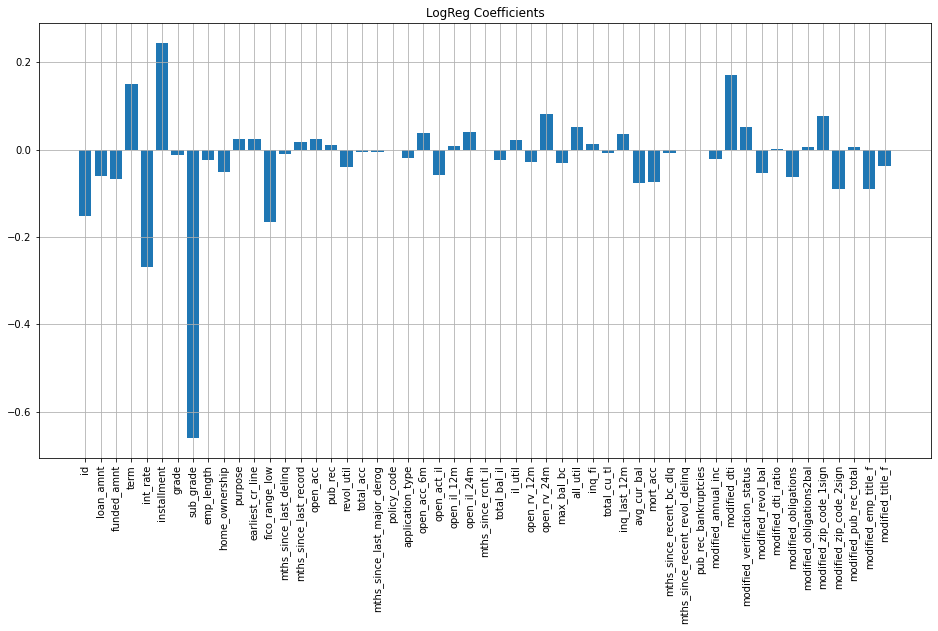

In [29]:
importance = model_lr.named_steps['classifier'].coef_[0]

plt.figure(figsize=(16, 8))
plt.bar([x for x in X_train.columns], importance)
plt.title('LogReg Coefficients')
plt.xticks(rotation=90)
plt.grid()
plt.show()

---

# 5 - ML-модель - CatBoost

Обучим более продвинутую модель — catboost:

In [30]:
%%time

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('classifier', CatBoostClassifier(random_state=54))
])

model_cat = pipeline.fit(X_train, y_train)

Learning rate set to 0.250806
0:	learn: 0.5535628	total: 224ms	remaining: 3m 43s
1:	learn: 0.4799775	total: 359ms	remaining: 2m 59s
2:	learn: 0.4447694	total: 476ms	remaining: 2m 38s
3:	learn: 0.4261870	total: 586ms	remaining: 2m 26s
4:	learn: 0.4151068	total: 711ms	remaining: 2m 21s
5:	learn: 0.4087154	total: 823ms	remaining: 2m 16s
6:	learn: 0.4052846	total: 929ms	remaining: 2m 11s
7:	learn: 0.4031263	total: 1.03s	remaining: 2m 8s
8:	learn: 0.4017699	total: 1.15s	remaining: 2m 6s
9:	learn: 0.4006878	total: 1.27s	remaining: 2m 5s
10:	learn: 0.4000007	total: 1.38s	remaining: 2m 4s
11:	learn: 0.3993327	total: 1.5s	remaining: 2m 3s
12:	learn: 0.3989581	total: 1.62s	remaining: 2m 3s
13:	learn: 0.3986225	total: 1.74s	remaining: 2m 2s
14:	learn: 0.3983161	total: 1.83s	remaining: 2m
15:	learn: 0.3980627	total: 1.97s	remaining: 2m 1s
16:	learn: 0.3978525	total: 2.07s	remaining: 1m 59s
17:	learn: 0.3976486	total: 2.16s	remaining: 1m 57s
18:	learn: 0.3974893	total: 2.25s	remaining: 1m 56s
19:	l

157:	learn: 0.3911591	total: 15.3s	remaining: 1m 21s
158:	learn: 0.3911327	total: 15.4s	remaining: 1m 21s
159:	learn: 0.3911158	total: 15.4s	remaining: 1m 21s
160:	learn: 0.3910983	total: 15.5s	remaining: 1m 20s
161:	learn: 0.3910719	total: 15.6s	remaining: 1m 20s
162:	learn: 0.3910558	total: 15.7s	remaining: 1m 20s
163:	learn: 0.3910312	total: 15.8s	remaining: 1m 20s
164:	learn: 0.3910132	total: 15.9s	remaining: 1m 20s
165:	learn: 0.3909869	total: 16s	remaining: 1m 20s
166:	learn: 0.3909672	total: 16s	remaining: 1m 20s
167:	learn: 0.3909465	total: 16.1s	remaining: 1m 19s
168:	learn: 0.3909210	total: 16.2s	remaining: 1m 19s
169:	learn: 0.3908989	total: 16.3s	remaining: 1m 19s
170:	learn: 0.3908764	total: 16.4s	remaining: 1m 19s
171:	learn: 0.3908502	total: 16.5s	remaining: 1m 19s
172:	learn: 0.3908334	total: 16.6s	remaining: 1m 19s
173:	learn: 0.3908106	total: 16.6s	remaining: 1m 19s
174:	learn: 0.3907917	total: 16.7s	remaining: 1m 18s
175:	learn: 0.3907764	total: 16.8s	remaining: 1m 1

316:	learn: 0.3883868	total: 29s	remaining: 1m 2s
317:	learn: 0.3883720	total: 29.1s	remaining: 1m 2s
318:	learn: 0.3883603	total: 29.2s	remaining: 1m 2s
319:	learn: 0.3883461	total: 29.2s	remaining: 1m 2s
320:	learn: 0.3883301	total: 29.3s	remaining: 1m 2s
321:	learn: 0.3883102	total: 29.5s	remaining: 1m 2s
322:	learn: 0.3882977	total: 29.6s	remaining: 1m 2s
323:	learn: 0.3882826	total: 29.7s	remaining: 1m 1s
324:	learn: 0.3882654	total: 29.8s	remaining: 1m 1s
325:	learn: 0.3882487	total: 29.9s	remaining: 1m 1s
326:	learn: 0.3882341	total: 30s	remaining: 1m 1s
327:	learn: 0.3882216	total: 30.1s	remaining: 1m 1s
328:	learn: 0.3882048	total: 30.2s	remaining: 1m 1s
329:	learn: 0.3881888	total: 30.3s	remaining: 1m 1s
330:	learn: 0.3881776	total: 30.4s	remaining: 1m 1s
331:	learn: 0.3881593	total: 30.5s	remaining: 1m 1s
332:	learn: 0.3881448	total: 30.6s	remaining: 1m 1s
333:	learn: 0.3881281	total: 30.7s	remaining: 1m 1s
334:	learn: 0.3881126	total: 30.8s	remaining: 1m 1s
335:	learn: 0.38

476:	learn: 0.3861564	total: 43.2s	remaining: 47.3s
477:	learn: 0.3861428	total: 43.3s	remaining: 47.2s
478:	learn: 0.3861300	total: 43.3s	remaining: 47.1s
479:	learn: 0.3861140	total: 43.4s	remaining: 47.1s
480:	learn: 0.3861041	total: 43.5s	remaining: 47s
481:	learn: 0.3860878	total: 43.6s	remaining: 46.9s
482:	learn: 0.3860753	total: 43.7s	remaining: 46.8s
483:	learn: 0.3860650	total: 43.8s	remaining: 46.7s
484:	learn: 0.3860462	total: 43.9s	remaining: 46.6s
485:	learn: 0.3860326	total: 44s	remaining: 46.5s
486:	learn: 0.3860225	total: 44s	remaining: 46.4s
487:	learn: 0.3860083	total: 44.1s	remaining: 46.3s
488:	learn: 0.3859941	total: 44.2s	remaining: 46.2s
489:	learn: 0.3859801	total: 44.3s	remaining: 46.1s
490:	learn: 0.3859690	total: 44.4s	remaining: 46s
491:	learn: 0.3859578	total: 44.5s	remaining: 45.9s
492:	learn: 0.3859470	total: 44.5s	remaining: 45.8s
493:	learn: 0.3859350	total: 44.6s	remaining: 45.7s
494:	learn: 0.3859252	total: 44.7s	remaining: 45.6s
495:	learn: 0.385914

635:	learn: 0.3841457	total: 57.1s	remaining: 32.7s
636:	learn: 0.3841312	total: 57.2s	remaining: 32.6s
637:	learn: 0.3841163	total: 57.3s	remaining: 32.5s
638:	learn: 0.3841015	total: 57.4s	remaining: 32.4s
639:	learn: 0.3840846	total: 57.5s	remaining: 32.3s
640:	learn: 0.3840682	total: 57.6s	remaining: 32.3s
641:	learn: 0.3840529	total: 57.7s	remaining: 32.2s
642:	learn: 0.3840432	total: 57.8s	remaining: 32.1s
643:	learn: 0.3840287	total: 57.8s	remaining: 32s
644:	learn: 0.3840190	total: 57.9s	remaining: 31.9s
645:	learn: 0.3840080	total: 58s	remaining: 31.8s
646:	learn: 0.3839962	total: 58.1s	remaining: 31.7s
647:	learn: 0.3839849	total: 58.2s	remaining: 31.6s
648:	learn: 0.3839733	total: 58.3s	remaining: 31.5s
649:	learn: 0.3839647	total: 58.4s	remaining: 31.4s
650:	learn: 0.3839493	total: 58.5s	remaining: 31.3s
651:	learn: 0.3839452	total: 58.5s	remaining: 31.2s
652:	learn: 0.3839308	total: 58.6s	remaining: 31.1s
653:	learn: 0.3839132	total: 58.7s	remaining: 31.1s
654:	learn: 0.38

794:	learn: 0.3822974	total: 1m 11s	remaining: 18.5s
795:	learn: 0.3822881	total: 1m 11s	remaining: 18.4s
796:	learn: 0.3822753	total: 1m 11s	remaining: 18.3s
797:	learn: 0.3822665	total: 1m 11s	remaining: 18.2s
798:	learn: 0.3822554	total: 1m 11s	remaining: 18.1s
799:	learn: 0.3822433	total: 1m 12s	remaining: 18s
800:	learn: 0.3822326	total: 1m 12s	remaining: 17.9s
801:	learn: 0.3822216	total: 1m 12s	remaining: 17.8s
802:	learn: 0.3822111	total: 1m 12s	remaining: 17.7s
803:	learn: 0.3821972	total: 1m 12s	remaining: 17.6s
804:	learn: 0.3821838	total: 1m 12s	remaining: 17.6s
805:	learn: 0.3821706	total: 1m 12s	remaining: 17.5s
806:	learn: 0.3821602	total: 1m 12s	remaining: 17.4s
807:	learn: 0.3821454	total: 1m 12s	remaining: 17.3s
808:	learn: 0.3821366	total: 1m 12s	remaining: 17.2s
809:	learn: 0.3821237	total: 1m 12s	remaining: 17.1s
810:	learn: 0.3821141	total: 1m 12s	remaining: 17s
811:	learn: 0.3821019	total: 1m 13s	remaining: 16.9s
812:	learn: 0.3820900	total: 1m 13s	remaining: 16.

950:	learn: 0.3804762	total: 1m 25s	remaining: 4.41s
951:	learn: 0.3804686	total: 1m 25s	remaining: 4.32s
952:	learn: 0.3804557	total: 1m 25s	remaining: 4.23s
953:	learn: 0.3804451	total: 1m 25s	remaining: 4.14s
954:	learn: 0.3804341	total: 1m 25s	remaining: 4.04s
955:	learn: 0.3804255	total: 1m 25s	remaining: 3.96s
956:	learn: 0.3804163	total: 1m 26s	remaining: 3.87s
957:	learn: 0.3804062	total: 1m 26s	remaining: 3.77s
958:	learn: 0.3803991	total: 1m 26s	remaining: 3.68s
959:	learn: 0.3803895	total: 1m 26s	remaining: 3.59s
960:	learn: 0.3803789	total: 1m 26s	remaining: 3.5s
961:	learn: 0.3803677	total: 1m 26s	remaining: 3.41s
962:	learn: 0.3803582	total: 1m 26s	remaining: 3.32s
963:	learn: 0.3803499	total: 1m 26s	remaining: 3.23s
964:	learn: 0.3803387	total: 1m 26s	remaining: 3.14s
965:	learn: 0.3803317	total: 1m 26s	remaining: 3.05s
966:	learn: 0.3803226	total: 1m 26s	remaining: 2.96s
967:	learn: 0.3803129	total: 1m 26s	remaining: 2.87s
968:	learn: 0.3803015	total: 1m 27s	remaining: 

In [31]:
print('Train GINI: %.5f' % (2*roc_auc_score(y_train, model_cat.predict_proba(X_train)[:,1])-1))
print('Train AUC-ROC: %.5f' % roc_auc_score(y_train, model_cat.predict_proba(X_train)[:,1]))
print('Train AUC-PR: %.5f' % average_precision_score(y_train, model_cat.predict_proba(X_train)[:,1]))
print('---')
print('Test GINI: %.5f' % (2*roc_auc_score(y_test, model_cat.predict_proba(X_test)[:,1])-1))
print('Test AUC-ROC: %.5f' % roc_auc_score(y_test, model_cat.predict_proba(X_test)[:,1]))
print('Test AUC-PR: %.5f' % average_precision_score(y_test, model_cat.predict_proba(X_test)[:,1]))

Train GINI: 0.49435
Train AUC-ROC: 0.74718
Train AUC-PR: 0.37981
---
Test GINI: 0.45632
Test AUC-ROC: 0.72816
Test AUC-PR: 0.09509


In [33]:
learn_error = pd.read_csv('catboost_info/learn_error.tsv', sep='\t')
test_error = pd.read_csv('catboost_info/test_error.tsv', sep='\t')

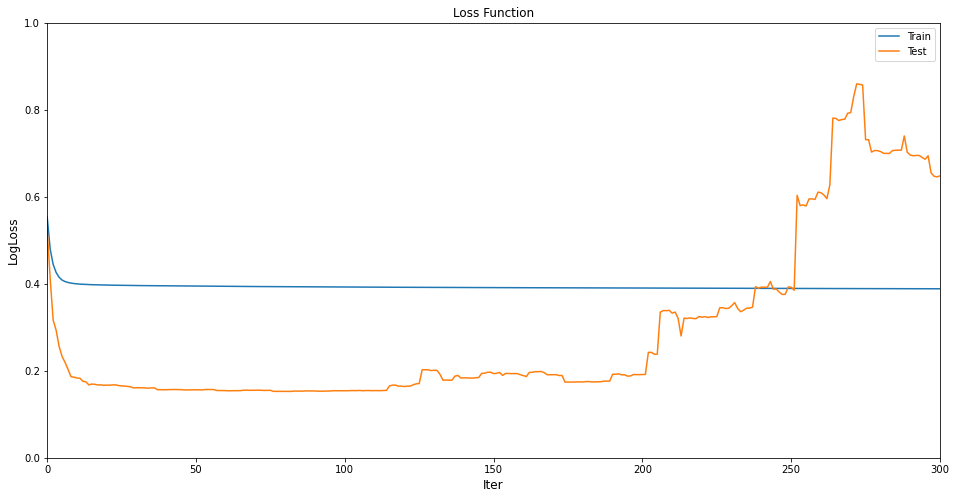

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(learn_error['iter'], learn_error['Logloss'], label='Train')
plt.plot(test_error['iter'], test_error['Logloss'], label='Test')
plt.xlim(0, 300)
plt.ylim(0, 1)
plt.title('Loss Function', size=12)
plt.xlabel('Iter', size=12)
plt.ylabel('LogLoss', size=12)
plt.legend()
plt.show()

Калибровка вероятностей:

In [35]:
def calibration(predict):
    PD0, Score0, Odd0 = 50, 600, 19
    Offset = PD0 / np.log(2)
    Factor = Score0 - Offset * np.log(Odd0)
    return round(Offset * np.log(1 / predict - 1) + Factor, 0)

In [36]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [37]:
calibrator_boost = LogisticRegression(random_state=54).fit(model_cat.predict_proba(X_train)[:,1].reshape(-1, 1), y_train)

df_train['predict_cat'] = calibrator_boost.predict_proba(model_cat.predict_proba(X_train)[:,1].reshape(-1, 1))[:,1]
df_train['score_cat'] = calibration(df_train['predict_cat'])

df_test['predict_cat'] = calibrator_boost.predict_proba(model_cat.predict_proba(X_test)[:,1].reshape(-1, 1))[:,1]
df_test['score_cat'] = calibration(df_test['predict_cat'])

In [38]:
calibrator_logreg = LogisticRegression(random_state=54).fit(model_lr.predict_proba(X_train)[:,1].reshape(-1, 1), y_train)

df_train['predict_lr'] = calibrator_logreg.predict_proba(model_lr.predict_proba(X_train)[:,1].reshape(-1, 1))[:,1]
df_train['score_lr'] = calibration(df_train['predict_lr'])

df_test['predict_lr'] = calibrator_logreg.predict_proba(model_lr.predict_proba(X_test)[:,1].reshape(-1, 1))[:,1]
df_test['score_lr'] = calibration(df_test['predict_cat'])

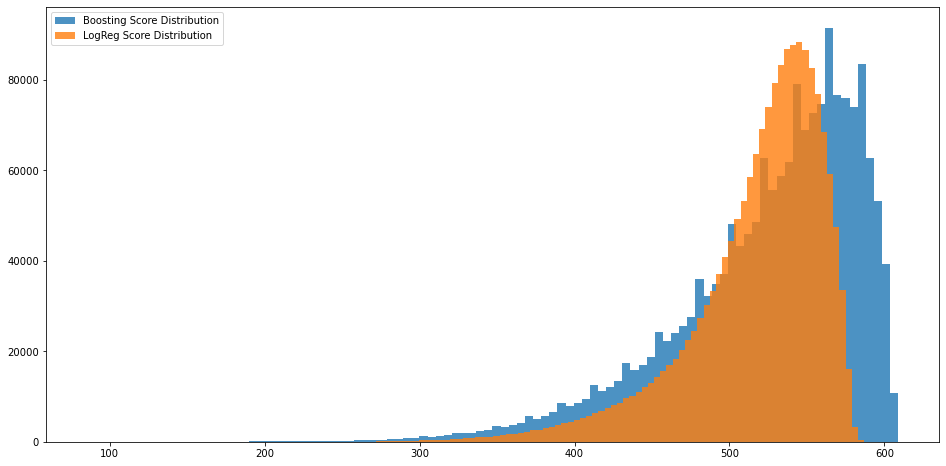

In [39]:
plt.figure(figsize=(16, 8))
plt.hist(df_train['score_cat'], bins=100, alpha=.8, label='Boosting Score Distribution')
plt.hist(df_train['score_lr'], bins=100, alpha=.8, label='LogReg Score Distribution')
plt.legend(loc='best')
plt.show()

In [40]:
%%time

df_train.to_csv('data/stage2_trainAfterPredictAndCalibration.csv', index=False)
df_test.to_csv('data/stage2_testAfterPredictAndCalibration.csv', index=False)

CPU times: user 1min 32s, sys: 9.5 s, total: 1min 41s
Wall time: 1min 49s


---

In [ ]:
%%time

df_train = pd.read_csv('data/stage2_trainAfterPredictAndCalibration.csv')
df_test = pd.read_csv('data/stage2_testAfterPredictAndCalibration.csv')

In [41]:
%%time

df_train_old = df_train.copy(deep=True)
df_train = pd.merge(
    left=df_train,
    right=df_acc[['id', 'issue_d']],
    on='id',
    how='left'
)

CPU times: user 1.12 s, sys: 1.97 s, total: 3.09 s
Wall time: 3.73 s


In [42]:
%%time

df_test_old = df_test.copy(deep=True)
df_test = pd.merge(
    left=df_test,
    right=df_acc[['id', 'issue_d']],
    on='id',
    how='left'
)

CPU times: user 470 ms, sys: 542 ms, total: 1.01 s
Wall time: 1.08 s


Коэффициент Джини для логистической регрессии:

In [43]:
dates = df_test['issue_d'].unique()

observations = []
metric = []
left_95 = []
right_95 = []

for d in dates:
    observations.append(df_test[df_test['issue_d'] == d].shape[0])
    y_true = df_test.loc[df_test['issue_d'] == d, 'target']
    probs = df_test.loc[df_test['issue_d'] == d, 'predict_lr']
    
    metric.append(2 * roc_auc_score(y_true, probs) - 1)
    gini = []
    
    for i in range(100):
        random_ind = np.random.choice(
            list(df_test.loc[df_test['issue_d'] == d].index),
            size=df_test.loc[df_test['issue_d'] == d].shape[0]
        )
        gini.append(2 * roc_auc_score(df_test.loc[random_ind, 'target'], df_test.loc[random_ind, 'predict_lr']) - 1)
        
    left_95.append(2 * roc_auc_score(y_true, probs) - 1 - t.ppf(0.95, len(gini)) * np.array(gini).std())
    right_95.append(2 * roc_auc_score(y_true, probs) - 1 + t.ppf(0.95, len(gini)) * np.array(gini).std())
    
lr_gini = pd.DataFrame({'date': dates, 'observations': observations, 'gini': metric, 'left_95': left_95, 'right_95': right_95})
lr_gini['date'] = pd.to_datetime(lr_gini['date'], format='%Y-%m-%d')
lr_gini = lr_gini.sort_values('date')

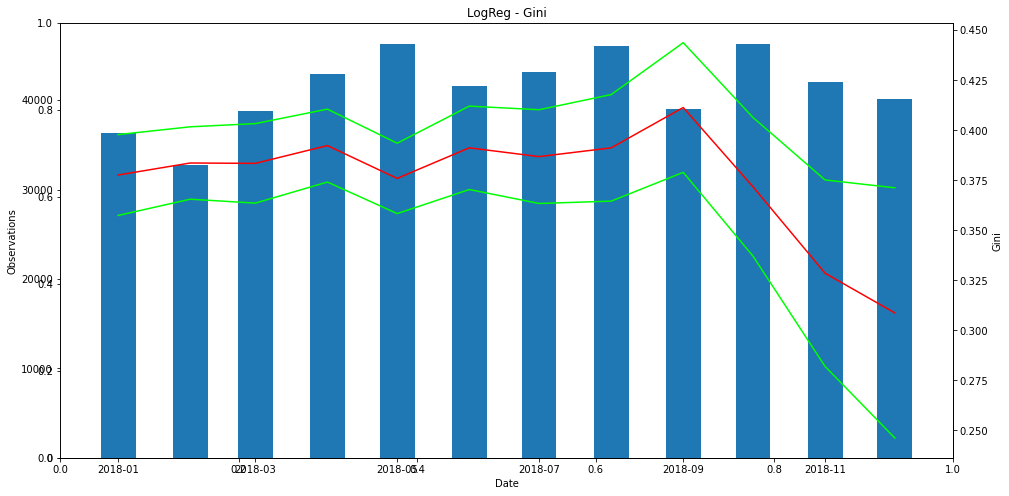

In [44]:
plt.figure(figsize = (16, 8))
plt.title('LogReg - Gini')

ax1 = plt.axes()
ax1.bar(lr_gini['date'], lr_gini['observations'], width=15)
ax1.set_ylabel('Observations')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(lr_gini['date'], lr_gini['gini'], color='r')
ax2.plot(lr_gini['date'], lr_gini['left_95'], color='lime')
ax2.plot(lr_gini['date'], lr_gini['right_95'], color='lime')
ax2.set_ylabel('Gini')

plt.show()

Вероятность дефолта для логистической регресии:

In [45]:
dates = df_test['issue_d'].unique()

observations = []
observations_pd = []
mean_pd = []

for d in dates:
    observations.append(df_test[df_test['issue_d'] == d].shape[0])
    mean_pd.append(df_test.loc[df_test['issue_d'] == d, 'predict_lr'].mean())
    observations_pd.append(
        df_test.loc[df_test['issue_d'] == d, 'target'].sum() /
        len(df_test.loc[df_test['issue_d'] == d, 'target'])
    )
    
lr_pd = pd.DataFrame({'date': dates, 'observations': observations, 'observations_pd': observations_pd, 'mean_pd': mean_pd})
lr_pd['date'] = pd.to_datetime(lr_pd['date'], format='%Y-%m-%d')
lr_pd = lr_pd.sort_values('date')

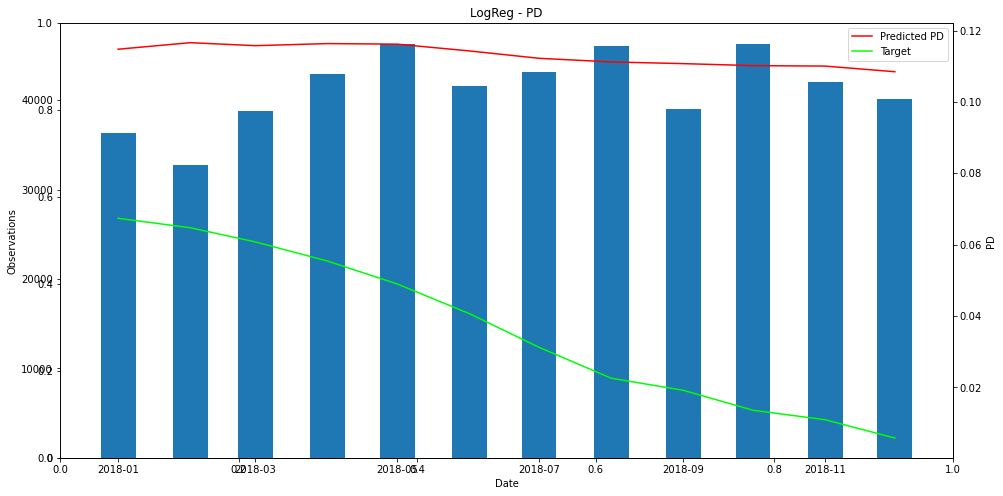

In [46]:
plt.figure(figsize = (16, 8))
plt.title('LogReg - PD')

ax1 = plt.axes()
ax1.bar(lr_pd['date'], lr_pd['observations'], width=15)
ax1.set_ylabel('Observations')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(lr_pd['date'], lr_pd['mean_pd'], color='r')
ax2.plot(lr_pd['date'], lr_pd['observations_pd'], color='lime')
ax2.set_ylabel('PD')

plt.legend(['Predicted PD', 'Target'])
plt.show()

Коэффициент Джини для catboost:

In [47]:
dates = df_test['issue_d'].unique()

observations = []
metric = []
left_95 = []
right_95 = []

for d in dates:
    observations.append(df_test[df_test['issue_d'] == d].shape[0])
    y_true = df_test.loc[df_test['issue_d'] == d, 'target']
    probs = df_test.loc[df_test['issue_d'] == d, 'predict_cat']
    
    metric.append(2 * roc_auc_score(y_true, probs) - 1)
    gini = []
    
    for i in range(100):
        random_ind = np.random.choice(
            list(df_test.loc[df_test['issue_d'] == d].index),
            size=df_test.loc[df_test['issue_d'] == d].shape[0]
        )
        gini.append(2 * roc_auc_score(df_test.loc[random_ind, 'target'], df_test.loc[random_ind, 'predict_cat']) - 1)
        
    left_95.append(2 * roc_auc_score(y_true, probs) - 1 - t.ppf(0.95, len(gini)) * np.array(gini).std())
    right_95.append(2 * roc_auc_score(y_true, probs) - 1 + t.ppf(0.95, len(gini)) * np.array(gini).std())
    
cat_gini = pd.DataFrame({'date': dates, 'observations': observations, 'gini': metric, 'left_95': left_95, 'right_95': right_95})
cat_gini['date'] = pd.to_datetime(cat_gini['date'], format='%Y-%m-%d')
cat_gini = cat_gini.sort_values('date')

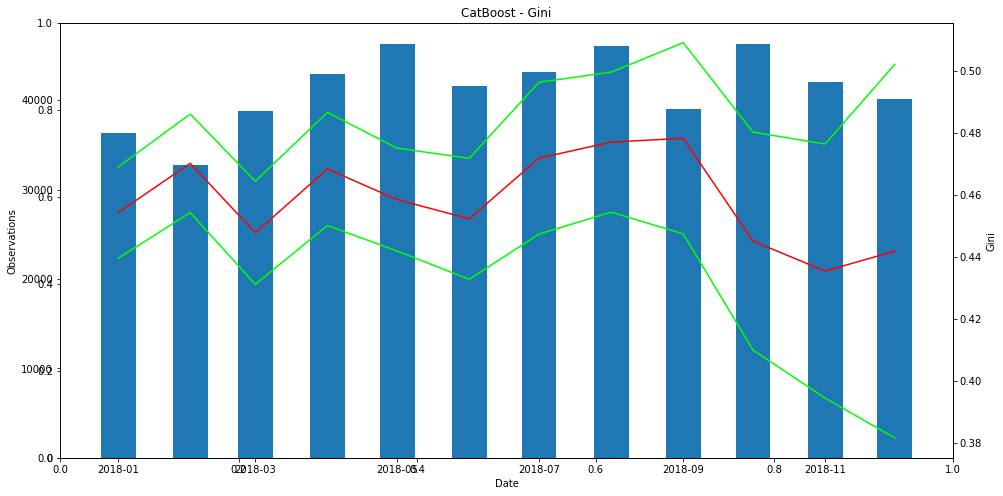

In [48]:
plt.figure(figsize = (16, 8))
plt.title('CatBoost - Gini')

ax1 = plt.axes()
ax1.bar(cat_gini['date'], cat_gini['observations'], width=15)
ax1.set_ylabel('Observations')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(cat_gini['date'], cat_gini['gini'], color='r')
ax2.plot(cat_gini['date'], cat_gini['left_95'], color='lime')
ax2.plot(cat_gini['date'], cat_gini['right_95'], color='lime')
ax2.set_ylabel('Gini')

plt.show()

Вероятность дефолта для catboost:

In [49]:
dates = df_test['issue_d'].unique()

observations = []
observations_pd = []
mean_pd = []

for d in dates:
    observations.append(df_test[df_test['issue_d'] == d].shape[0])
    mean_pd.append(df_test.loc[df_test['issue_d'] == d, 'predict_cat'].mean())
    observations_pd.append(
        df_test.loc[df_test['issue_d'] == d, 'target'].sum() /
        len(df_test.loc[df_test['issue_d'] == d, 'target'])
    )
    
cat_pd = pd.DataFrame({'date': dates, 'observations': observations, 'observations_pd': observations_pd, 'mean_pd': mean_pd})
cat_pd['date'] = pd.to_datetime(cat_pd['date'], format='%Y-%m-%d')
cat_pd = cat_pd.sort_values('date')

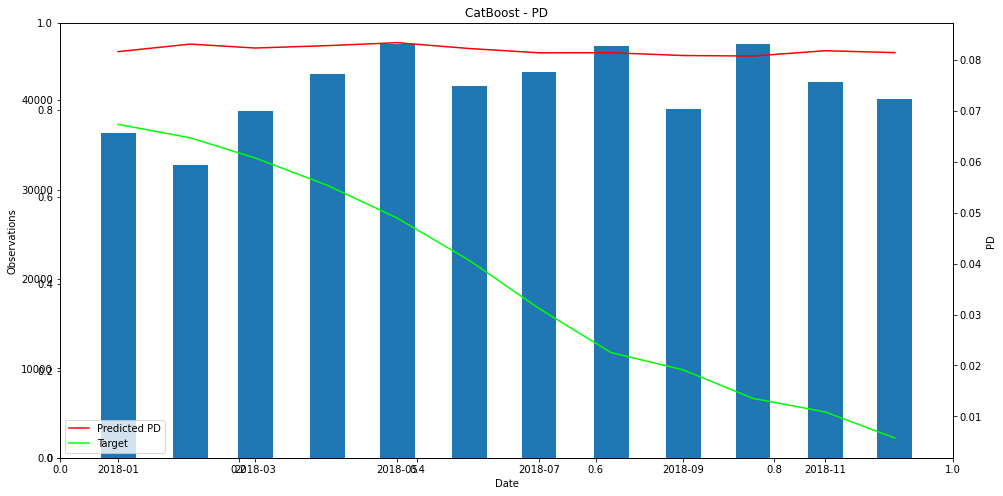

In [50]:
plt.figure(figsize = (16, 8))
plt.title('CatBoost - PD')

ax1 = plt.axes()
ax1.bar(cat_pd['date'], cat_pd['observations'], width=15)
ax1.set_ylabel('Observations')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(cat_pd['date'], cat_pd['mean_pd'], color='r')
ax2.plot(cat_pd['date'], cat_pd['observations_pd'], color='lime')
ax2.set_ylabel('PD')

plt.legend(['Predicted PD', 'Target'])
plt.show()

In [51]:
def gini(values):
    # http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    
    values = values.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(values) < 0:
        values -= np.amin(values) #values cannot be negative
    values += 0.0000001 #values cannot be 0
    values = np.sort(values) #values must be sorted

    return ((np.sum((2 * np.arange(1, values.shape[0]+1) - values.shape[0]  - 1) * values)) / (values.shape[0] * np.sum(values))) #Gini coefficient

In [52]:
features = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'purpose', 'earliest_cr_line',
    'fico_range_low', 'mths_since_last_delinq', 'mths_since_last_record',
    'open_acc', 'pub_rec', 'revol_util', 'total_acc',
    'mths_since_last_major_derog', 'policy_code', 'application_type',
    'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
    'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
    'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
    'inq_last_12m', 'avg_cur_bal', 'mort_acc', 'mths_since_recent_bc_dlq',
    'mths_since_recent_revol_delinq', 'pub_rec_bankruptcies',
    'modified_annual_inc', 'modified_dti', 'modified_verification_status',
    'modified_revol_bal', 'modified_dti_ratio', 'modified_obligations',
    'modified_obligations2bal', 'modified_zip_code_1sign',
    'modified_zip_code_2sign', 'modified_pub_rec_total',
    'modified_emp_title_f', 'modified_title_f'
]

In [53]:
gini_lr = []
for col in tqdm(features):
    mean_gini = gini( df_test[col].to_numpy().astype('float64') )
    gini_lr.append(mean_gini)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 38.01it/s]


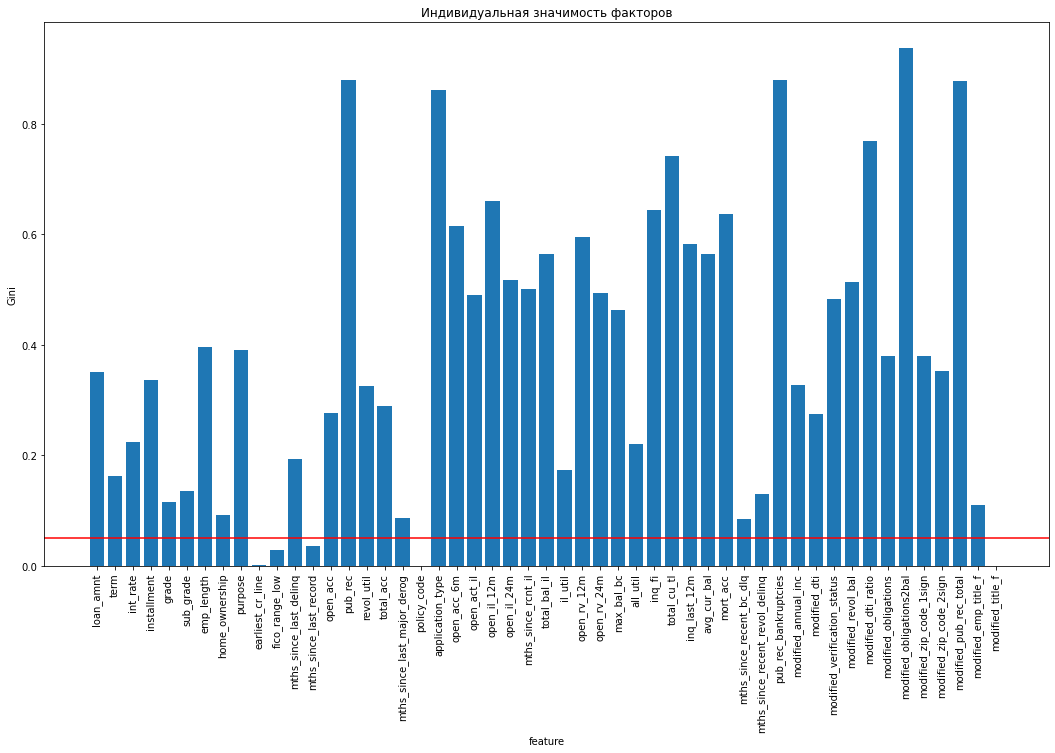

In [54]:
fig, ax = plt.subplots(figsize=(18,10))

ax.set_title('Индивидуальная значимость факторов')
ax.bar(features, gini_lr)
ax.set_ylabel('Gini')
ax.set_xlabel('feature')
plt.xticks(rotation = 90)
plt.axhline(0.05, color='red')

plt.show()

---

In [55]:
import math
import scipy

In [56]:
def calc_vasicek_prob(x, p, rho):
    a1   = scipy.stats.norm.ppf(p, loc=0.0, scale=1.0)
    arg1 = scipy.stats.norm.ppf(x, loc=0.0, scale=1.0)
    arg2 = (math.sqrt(1 - rho) * arg1 - a1) / math.sqrt(rho)
    return scipy.stats.norm.cdf(arg2, loc=0.0, scale=1.0)


def calc_vasicek_999_q(p, rho):
    return calc_vasicek_prob(0.999, 1-p, 1-rho)


def calc_confidence(loss_array, confidence):
    loss_array = np.sort( np.array(loss_array) )
    h = scipy.stats.sem(loss_array) * t.ppf((1 + confidence) / 2.0, len(loss_array) - 1)
    return np.mean(loss_array) - h, np.mean(loss_array) + h

In [57]:
data_x = np.linspace(0, 1, 200)
dens = [calc_vasicek_prob(i, df_test.predict_lr.mean(), 0.06) for i in data_x]

p_lr = df_test.predict_lr.mean()
result_lr = np.diff(dens) / np.diff(data_x)
q_999 = calc_vasicek_999_q(df_test.predict_lr.mean(), 0.06)

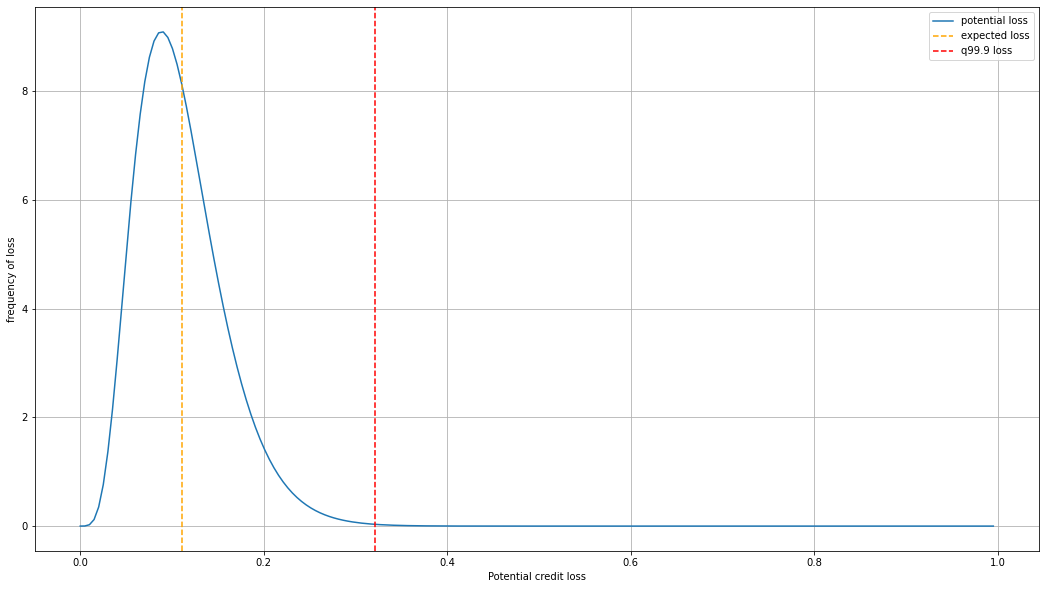

In [58]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(data_x[:-1], result_lr, label='potential loss')
ax.axvline(data_x[np.argmin(abs(data_x - p_lr)) ], linestyle='--', color='orange', label='expected loss')
ax.axvline(data_x[np.argmin(abs(data_x - q_999))], linestyle='--', color='red',    label='q99.9 loss')

ax.set_xlabel('Potential credit loss')
ax.set_ylabel('frequency of loss')

plt.grid()
plt.legend()

plt.show()

In [59]:
ml, mh = calc_confidence(df_test.predict_lr, 0.999)

print(f"""
Ожидаемые потери (математическое ожидание):\t{df_test.funded_amnt.sum() * df_test.predict_lr.mean()}
99% доверительный интервал:\t[{df_test.funded_amnt.sum() * ml}; {df_test.funded_amnt.sum() * mh}]
Неожидаемые потери VaR 99.9%:\t{df_test.funded_amnt.sum() * q_999}
Необходимый капитал:\t{abs( df_test.funded_amnt.sum() * q_999 - df_test.funded_amnt.sum() * df_test.predict_lr.mean() )}
""")


Ожидаемые потери (математическое ожидание):	896558799.5412527
99% доверительный интервал:	[894681861.9606946; 898435737.1218159]
Неожидаемые потери VaR 99.9%:	2538187094.855663
Необходимый капитал:	1641628295.3144102



---

In [60]:
data_x = np.linspace(0, 1, 200)
dens = [calc_vasicek_prob(i, df_test.predict_cat.mean(), 0.06) for i in data_x]

p_cat = df_test.predict_cat.mean()
result_cat = np.diff(dens) / np.diff(data_x)
q_999 = calc_vasicek_999_q(df_test.predict_cat.mean(), 0.06)

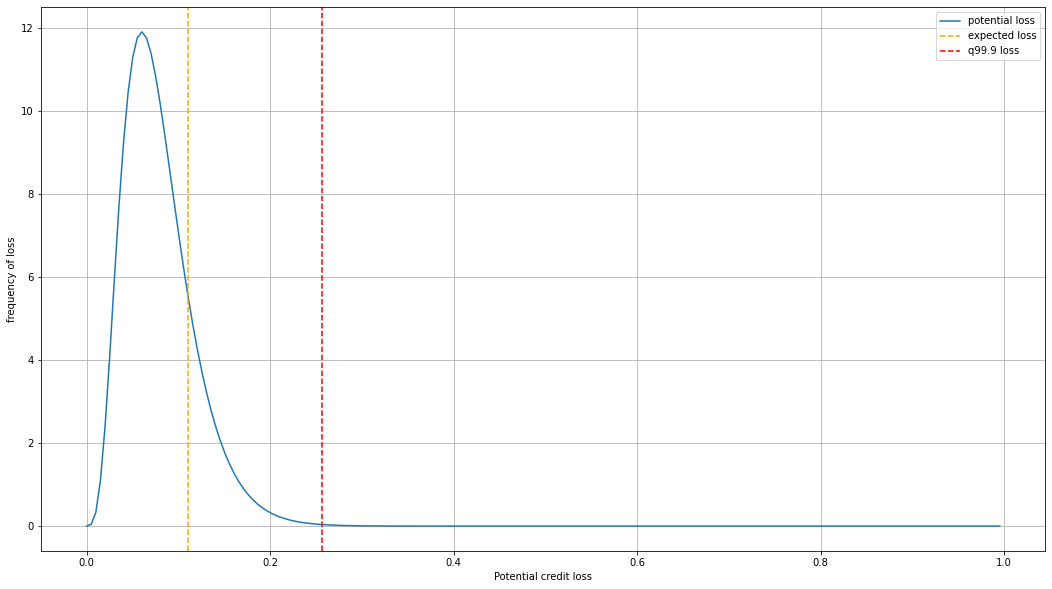

In [61]:
fig, ax = plt.subplots(figsize=(18,10))

ax.plot(data_x[:-1], result_cat, label='potential loss')
ax.axvline(data_x[np.argmin(abs(data_x - p_lr)) ], linestyle='--', color='orange', label='expected loss')
ax.axvline(data_x[np.argmin(abs(data_x - q_999))], linestyle='--', color='red',    label='q99.9 loss')

ax.set_xlabel('Potential credit loss')
ax.set_ylabel('frequency of loss')

plt.grid()
plt.legend()

plt.show()

In [62]:
ml, mh = calc_confidence(df_test.predict_cat, 0.999)

print(f"""
Ожидаемые потери (математическое ожидание):\t{df_test.funded_amnt.sum() * df_test.predict_cat.mean()}
99% доверительный интервал:\t[{df_test.funded_amnt.sum() * ml}; {df_test.funded_amnt.sum() * mh}]
Неожидаемые потери VaR 99.9%:\t{df_test.funded_amnt.sum() * q_999}
Необходимый капитал:\t{abs( df_test.funded_amnt.sum() * q_999 - df_test.funded_amnt.sum() * df_test.predict_cat.mean() )}
""")


Ожидаемые потери (математическое ожидание):	650144282.8955256
99% доверительный интервал:	[648106421.4484571; 652182144.3425986]
Неожидаемые потери VaR 99.9%:	2032822278.795135
Необходимый капитал:	1382677995.8996096



---

# 6 - Считаем оптимальную константную стратегию

In [63]:
df_train['term_int'] = pd.Series(np.random.randn(len(df_train)), index=df_train.index)
df_train['interest_val'] = pd.Series(np.random.randn(len(df_train)), index=df_train.index)

In [64]:
df_train.interest_val = df_train.funded_amnt/(df_train.int_rate+df_train.int_rate/(((1+df_train.int_rate)**df_train.term_int)-1)*df_train.term_int)

In [65]:
df_tmp=df_train.sort_values(by=['predict_cat'])

In [66]:
df_tmp.reset_index(inplace=True)

In [67]:
def get_interest_sum(df):
    interest_sum = np.zeros(len(df))
    for i in range(len(df)):
        if i == 1:
            if df.loc[0,'target'] == 0:
                interest_sum[0] = df.loc[0, 'interest_val']
            else:
                interest_sum[0] = -df.loc[0, 'funded_amnt']
        if df.loc[i,'target'] == 0:
            interest_sum[i] = interest_sum[i-1] + df.loc[i,'interest_val']
        else:
            interest_sum[i] = interest_sum[i-1] - df.loc[i,'funded_amnt']
    return interest_sum

In [68]:
sum_boost = get_interest_sum(df_tmp)

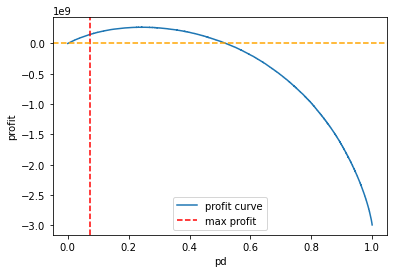

In [70]:
plt.plot( np.linspace(0, 1, len(df_tmp)), sum_boost, label='profit curve' )

plt.axvline( df_tmp.loc[np.argmax(sum_boost), 'predict_cat'], color='red', label='max profit', ls='--' )
plt.axhline( 0, color='orange', ls='--' )

plt.xlabel('pd')
plt.ylabel('profit')

plt.legend()
plt.show()

In [72]:
print('максимальная прибыль при уровне pd = %4f для бустинга' %(df_tmp.loc[np.argmax(sum_boost), 'score_cat']))
print('максимальная прибыль при уровне pd = %4f для бустинга' %(df_tmp.loc[np.argmax(sum_boost), 'predict_cat']))

максимальная прибыль при уровне pd = 572.000000 для бустинга
максимальная прибыль при уровне pd = 0.072278 для бустинга


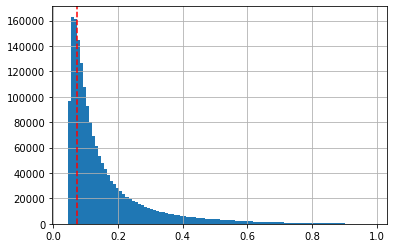

In [74]:
df_tmp['predict_cat'].hist(bins=100)
plt.axvline(df_tmp.loc[np.argmax(sum_boost), 'predict_cat'], color='red', ls='--')

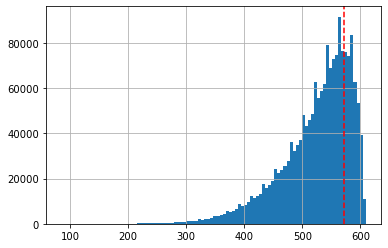

In [75]:
df_tmp['score_cat'].hist(bins=100)
plt.axvline(572, color='red', ls='--')

---

In [76]:
df_tmp = df_train.sort_values(by=['score_cat'], ascending=False)

In [77]:
df_tmp.reset_index(inplace=True)

In [78]:
sum_boost = get_interest_sum(df_tmp)

In [80]:
print('максимальная прибыль при уровне pd = %4f для бустинга' %(df_tmp.loc[np.argmax(sum_boost), 'score_cat']))
print('максимальная прибыль при уровне pd = %4f для бустинга' %(df_tmp.loc[np.argmax(sum_boost), 'predict_cat']))

максимальная прибыль при уровне pd = 570.000000 для бустинга
максимальная прибыль при уровне pd = 0.074085 для бустинга


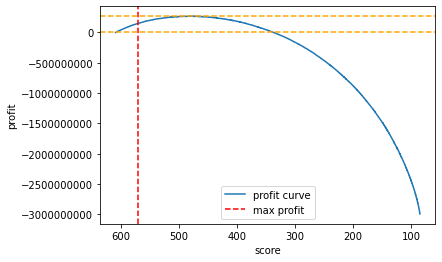

In [83]:
plt.plot( np.linspace(df_tmp.score_cat.min(), df_tmp.score_cat.max(), len(df_tmp))[::-1], sum_boost, label='profit curve' )
plt.gca().invert_xaxis()

plt.axvline( df_tmp.loc[np.argmax(sum_boost), 'score_cat'], color='red', label='max profit', ls='--' )
plt.axhline( sum_boost.max(), color='orange', ls='--' )
plt.axhline( 0, color='orange', ls='--' )

plt.xlabel('score')
plt.ylabel('profit')
plt.ticklabel_format(style='plain')

plt.legend()
plt.show()

---

# 7 - Сохранение финальных данных для использования в OpenAI Gym

In [84]:
df_tmp = df_acc.drop(columns=['issue_d', 'target'])

In [85]:
df_tmp['predict_cat'] = calibrator_boost.predict_proba(model_cat.predict_proba(df_tmp)[:,1].reshape(-1, 1))[:,1]
df_tmp['score_cat'] = calibration(df_tmp['predict_cat'])

In [86]:
df_tmp = pd.merge(
    left=df_tmp,
    right=df_acc[['id', 'issue_d', 'target']],
    on='id',
    how='left'
)

In [87]:
df_tmp.to_csv('data/stage3_finalWithCatboost.csv', index=False)